In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'ruslangokhmanjh'
os.environ['KAGGLE_KEY'] = '7a976a45a77cad69be7de9827c3ee494'

# FULL DATASET

In [ ]:
!kaggle datasets download -d mariaherrerot/eyepacspreprocess

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!unzip eyepacspreprocess.zip

Archive:  eyepacspreprocess.zip
replace eyepacs_preprocess/eyepacs_preprocess/10003_left.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Library import

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset, RandomSampler
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms, models, utils, ops
from skimage import io, transform
from torchsummary import summary
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
import torchvision

In [ ]:
import os
for dirname, _, filenames in os.walk('eyepacs_preprocess'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Streaming output truncated to the last 5000 lines.
eyepacs_preprocess/eyepacs_preprocess/31324_left.jpeg
eyepacs_preprocess/eyepacs_preprocess/13991_left.jpeg
eyepacs_preprocess/eyepacs_preprocess/23575_right.jpeg
eyepacs_preprocess/eyepacs_preprocess/12946_right.jpeg
eyepacs_preprocess/eyepacs_preprocess/30967_right.jpeg
eyepacs_preprocess/eyepacs_preprocess/33529_left.jpeg
eyepacs_preprocess/eyepacs_preprocess/9147_right.jpeg
eyepacs_preprocess/eyepacs_preprocess/30352_right.jpeg
eyepacs_preprocess/eyepacs_preprocess/43863_left.jpeg
eyepacs_preprocess/eyepacs_preprocess/7172_right.jpeg
eyepacs_preprocess/eyepacs_preprocess/26315_right.jpeg
eyepacs_preprocess/eyepacs_preprocess/26234_right.jpeg
eyepacs_preprocess/eyepacs_preprocess/14468_right.jpeg
eyepacs_preprocess/eyepacs_preprocess/10903_right.jpeg
eyepacs_preprocess/eyepacs_preprocess/14008_left.jpeg
eyepacs_preprocess/eyepacs_preprocess/17474_right.jpeg
eyepacs_preprocess/eyepacs_preprocess/2780_right.jpeg
eyepacs_preprocess/eye

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
class EyePACSDataset(Dataset):
    def __init__(self, img_dir, df, transform=None):
        self.img_dir = img_dir
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx, 0] + '.jpeg')
        image = Image.open(img_path)
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
transform = transforms.Compose([transforms.Resize((299, 299)), # 299, 299 for inception, 224, 224 for other
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

In [ ]:
df = pd.read_csv('trainLabels.csv')

In [ ]:
dataset = EyePACSDataset('eyepacs_preprocess/eyepacs_preprocess', df, transform=transform)

In [ ]:
# Divide the dataset into train, test, and validation sets
num_train = int(len(dataset) * 0.7)
num_test = int(len(dataset) * 0.15)
num_val = len(dataset) - num_train - num_test

train_indices = np.random.choice(len(dataset), num_train, replace=False)
test_val_indices = list(set(range(len(dataset))) - set(train_indices))
test_indices = np.random.choice(test_val_indices, num_test, replace=False)
val_indices = list(set(test_val_indices) - set(test_indices))

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)
val_dataset = Subset(dataset, val_indices)

# Create data loaders for each set
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)


## First model - VGG-16

In [ ]:
model1 = models.vgg16(pretrained=True)
for param in model1.parameters():
    param.requires_grad = False

num_features = model1.classifier[6].in_features
features = list(model1.classifier.children())[:-1]
features.extend([nn.Linear(num_features, 5)])
model1.classifier = nn.Sequential(*features)
model1.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from tqdm import tqdm

n_epochs = 10
best_accuracy = 0.0

for epoch in range(n_epochs):
    train_loss = 0.0
    train_accuracy = 0.0
    val_loss = 0.0
    val_accuracy = 0.0

    # Train the model
    model1.train()
    for images, labels in tqdm(train_loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model1(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_accuracy += torch.sum(preds == labels.data)

    train_loss = train_loss / len(train_loader.sampler)
    train_accuracy = train_accuracy.double() / len(train_loader.sampler)

    # Validate the model
    model1.eval()
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)

            outputs = model1(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_accuracy += torch.sum(preds == labels.data)

    val_loss = val_loss / len(val_loader.sampler)
    val_accuracy = val_accuracy.double() / len(val_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f}'.format(epoch+1, train_loss, train_accuracy))
    print('\t\tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(val_loss, val_accuracy))

    # Save the model weights if validation accuracy increases
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model1.state_dict(), 'best_model1.pth')


Validation: 100%|██████████| 165/165 [02:11<00:00,  1.25it/s]


Epoch: 1 	Training Loss: 0.900900 	Training Accuracy: 0.717111
		Validation Loss: 0.838067 	Validation Accuracy: 0.724511


Validation: 100%|██████████| 165/165 [02:12<00:00,  1.25it/s]


Epoch: 2 	Training Loss: 0.904918 	Training Accuracy: 0.711821
		Validation Loss: 0.837110 	Validation Accuracy: 0.725081


Validation: 100%|██████████| 165/165 [02:12<00:00,  1.25it/s]


Epoch: 3 	Training Loss: 0.902175 	Training Accuracy: 0.713611
		Validation Loss: 0.848911 	Validation Accuracy: 0.725650


Validation: 100%|██████████| 165/165 [02:12<00:00,  1.25it/s]


Epoch: 4 	Training Loss: 0.900035 	Training Accuracy: 0.711495
		Validation Loss: 0.839278 	Validation Accuracy: 0.727359


Validation: 100%|██████████| 165/165 [02:11<00:00,  1.25it/s]


Epoch: 5 	Training Loss: 0.910525 	Training Accuracy: 0.711251
		Validation Loss: 0.826006 	Validation Accuracy: 0.724891


Validation: 100%|██████████| 165/165 [02:13<00:00,  1.24it/s]


Epoch: 6 	Training Loss: 0.902628 	Training Accuracy: 0.712635
		Validation Loss: 0.831756 	Validation Accuracy: 0.721283


Validation: 100%|██████████| 165/165 [02:13<00:00,  1.23it/s]


Epoch: 7 	Training Loss: 0.903777 	Training Accuracy: 0.712553
		Validation Loss: 0.849678 	Validation Accuracy: 0.721473


Validation: 100%|██████████| 165/165 [02:13<00:00,  1.24it/s]


Epoch: 8 	Training Loss: 0.916415 	Training Accuracy: 0.708159
		Validation Loss: 0.888991 	Validation Accuracy: 0.724321


Validation: 100%|██████████| 165/165 [02:13<00:00,  1.24it/s]


Epoch: 9 	Training Loss: 0.898500 	Training Accuracy: 0.710315
		Validation Loss: 0.856940 	Validation Accuracy: 0.727929


Validation: 100%|██████████| 165/165 [02:14<00:00,  1.23it/s]

Epoch: 10 	Training Loss: 0.903154 	Training Accuracy: 0.711211
		Validation Loss: 0.853319 	Validation Accuracy: 0.723752


In [ ]:
# initialize some variables to keep track of testing statistics
test_loss = 0.0
test_accuracy = 0.0

# iterate over the test data
for images, labels in tqdm(test_loader, desc='Testing'):
    images, labels = images.to(device), labels.to(device)

    # compute the model output
    outputs = model1(images)

    # calculate the loss
    loss = criterion(outputs, labels)
    test_loss += loss.item() * images.size(0)

    # calculate the accuracy
    _, preds = torch.max(outputs, 1)
    test_accuracy += torch.sum(preds == labels.data)

test_loss = test_loss / len(test_loader.sampler)
test_accuracy = test_accuracy.double() / len(test_loader.sampler)
print(' \tTest Loss: {:.6f} \tTest Accuracy: {:.6f}'.format( test_loss,test_accuracy))

Testing: 100%|██████████| 165/165 [02:15<00:00,  1.22it/s]

 	Test Loss: 0.816887 	Test Accuracy: 0.733954


In [ ]:
pathpth1 = '/content/best_model1.pth'
print(torch.load(pathpth1))


OrderedDict([('features.0.weight', tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
          [-5.8312e-01,  3.5655e-01,  7.6566e-01],
          [-6.9022e-01, -4.8019e-02,  4.8409e-01]],

         [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
          [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
          [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],

         [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
          [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
          [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],


        [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
          [-4.2805e-01, -2.4349e-01,  2.4628e-01],
          [-2.5066e-01,  1.4177e-01, -5.4864e-03]],

         [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
          [-8.4127e-01, -3.5176e-01,  5.6398e-01],
          [-2.4194e-01,  5.1928e-01,  5.3915e-01]],

         [[-3.1432e-01, -3.7048e-01, -1.3094e-01],
          [-4.7144e-01, -1.5503e-01,  3.4589e-01],
          [ 5.4384e-02,  5.8683e-01,  4.9580e-01]]],


        [[[ 1.7715e-01,  5.2149

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Second model - Inception_v3

In [ ]:
model3 = models.inception_v3(pretrained=True)

# Freeze all layers
for param in model3.parameters():
    param.requires_grad = False

# Replace the last fully connected layer
num_features = model3.fc.in_features
model3.fc = nn.Linear(num_features, 6)



#num_features = model3.classifier[6].in_features
#features = list(model3.classifier.children())[:-1]
#features.extend([nn.Linear(num_features, 5)])
#model3.classifier = nn.Sequential(*features)
model3.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.fc.parameters())

In [ ]:
from tqdm import tqdm

n_epochs = 5
best_accuracy = 0.0

for epoch in range(n_epochs):
    train_loss = 0.0
    train_accuracy = 0.0
    val_loss = 0.0
    val_accuracy = 0.0

    # Train the model
    model3.train()
    for images, labels in tqdm(train_loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model3(images)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs.logits, 1)
        train_accuracy += torch.sum(preds == labels.data)

    train_loss = train_loss / len(train_loader.sampler)
    train_accuracy = train_accuracy.double() / len(train_loader.sampler)

    # Validate the model
    model3.eval()
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)

            outputs = model3(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_accuracy += torch.sum(preds == labels.data)

    val_loss = val_loss / len(val_loader.sampler)
    val_accuracy = val_accuracy.double() / len(val_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f}'.format(epoch+1, train_loss, train_accuracy))
    print('\t\tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(val_loss, val_accuracy))

    # Save the model weights if validation accuracy increases
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model3.state_dict(), 'best_model3.pth')


Validation: 100%|██████████| 83/83 [02:15<00:00,  1.64s/it]


Epoch: 1 	Training Loss: 0.802057 	Training Accuracy: 0.738637
		Validation Loss: 0.800166 	Validation Accuracy: 0.741409


Validation: 100%|██████████| 83/83 [02:16<00:00,  1.65s/it]


Epoch: 2 	Training Loss: 0.791123 	Training Accuracy: 0.740305
		Validation Loss: 0.774712 	Validation Accuracy: 0.738371


Validation: 100%|██████████| 83/83 [02:18<00:00,  1.67s/it]


Epoch: 3 	Training Loss: 0.789995 	Training Accuracy: 0.739858
		Validation Loss: 0.782849 	Validation Accuracy: 0.738371


Validation: 100%|██████████| 83/83 [02:16<00:00,  1.65s/it]


Epoch: 4 	Training Loss: 0.786790 	Training Accuracy: 0.741322
		Validation Loss: 0.799009 	Validation Accuracy: 0.735903


Validation: 100%|██████████| 83/83 [02:17<00:00,  1.66s/it]


Epoch: 5 	Training Loss: 0.796531 	Training Accuracy: 0.735300
		Validation Loss: 0.785802 	Validation Accuracy: 0.741788


In [ ]:
# initialize some variables to keep track of testing statistics
test_loss = 0.0
test_accuracy = 0.0

# iterate over the test data
for images, labels in tqdm(test_loader, desc='Testing'):
    images, labels = images.to(device), labels.to(device)

    # compute the model output
    outputs = model3(images)

    # calculate the loss
    loss = criterion(outputs, labels)
    test_loss += loss.item() * images.size(0)

    # calculate the accuracy
    _, preds = torch.max(outputs, 1)
    test_accuracy += torch.sum(preds == labels.data)

test_loss = test_loss / len(test_loader.sampler)
test_accuracy = test_accuracy.double() / len(test_loader.sampler)
print(' \tTest Loss: {:.6f} \tTest Accuracy: {:.6f}'.format( test_loss,test_accuracy))

Testing: 100%|██████████| 5266/5266 [03:15<00:00, 26.94it/s]

 	Test Loss: 0.795086 	Test Accuracy: 0.740600


## Third Model - MobileNet_v2

In [ ]:
model = models.mobilenet_v2(pretrained=True)
num_ftrs=model.classifier[1].in_features
model.classifier[1]=nn.Linear(num_ftrs,5)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
all_train_loss=[]
all_train_accuracy=[]
all_val_loss=[]
all_val_accuracy=[]


In [ ]:
n_epochs = 10
best_accuracy = 0.0

for epoch in range(n_epochs):
    train_loss = 0.0
    train_accuracy = 0.0
    val_loss = 0.0
    val_accuracy = 0.0

    # Train the model
    model.train()
    for images, labels in tqdm(train_loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_accuracy += torch.sum(preds == labels.data)

    train_loss = train_loss / len(train_loader.sampler)
    train_accuracy = train_accuracy.double() / len(train_loader.sampler)

    # Validate the model
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_accuracy += torch.sum(preds == labels.data)

    val_loss = val_loss / len(val_loader.sampler)
    val_accuracy = val_accuracy.double() / len(val_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f}'.format(epoch+1, train_loss, train_accuracy))
    print('\t\tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(val_loss, val_accuracy))

    # Save the model weights if validation accuracy increases
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)
    all_train_accuracy.append(train_accuracy)
    all_val_accuracy.append(val_accuracy)





Validation: 100%|██████████| 165/165 [02:38<00:00,  1.04it/s]


Epoch: 1 	Training Loss: 0.733999 	Training Accuracy: 0.758332
		Validation Loss: 0.658357 	Validation Accuracy: 0.781280


Validation: 100%|██████████| 165/165 [02:39<00:00,  1.04it/s]


Epoch: 2 	Training Loss: 0.657057 	Training Accuracy: 0.783642
		Validation Loss: 0.632687 	Validation Accuracy: 0.786026


Validation: 100%|██████████| 165/165 [02:39<00:00,  1.03it/s]


Epoch: 3 	Training Loss: 0.625972 	Training Accuracy: 0.793286
		Validation Loss: 0.654924 	Validation Accuracy: 0.783368


Validation: 100%|██████████| 165/165 [02:39<00:00,  1.03it/s]


Epoch: 4 	Training Loss: 0.607173 	Training Accuracy: 0.800244
		Validation Loss: 0.618331 	Validation Accuracy: 0.799886


Validation: 100%|██████████| 165/165 [02:38<00:00,  1.04it/s]


Epoch: 5 	Training Loss: 0.587962 	Training Accuracy: 0.806551
		Validation Loss: 0.623985 	Validation Accuracy: 0.796469


Validation: 100%|██████████| 165/165 [02:39<00:00,  1.04it/s]


Epoch: 6 	Training Loss: 0.574751 	Training Accuracy: 0.808667
		Validation Loss: 0.629936 	Validation Accuracy: 0.800646


Validation: 100%|██████████| 165/165 [02:41<00:00,  1.02it/s]


Epoch: 7 	Training Loss: 0.558098 	Training Accuracy: 0.814323
		Validation Loss: 0.605192 	Validation Accuracy: 0.797798


Validation: 100%|██████████| 165/165 [02:38<00:00,  1.04it/s]


Epoch: 8 	Training Loss: 0.533814 	Training Accuracy: 0.822625
		Validation Loss: 0.635617 	Validation Accuracy: 0.789444


Validation: 100%|██████████| 165/165 [02:40<00:00,  1.03it/s]


Epoch: 9 	Training Loss: 0.523571 	Training Accuracy: 0.823723
		Validation Loss: 0.601781 	Validation Accuracy: 0.796089


Validation: 100%|██████████| 165/165 [02:38<00:00,  1.04it/s]

Epoch: 10 	Training Loss: 0.505624 	Training Accuracy: 0.828403
		Validation Loss: 0.638834 	Validation Accuracy: 0.790773


In [ ]:
with open('best_model.pth', 'rb') as f:
    model.load_state_dict(torch.load(f))


In [ ]:
# initialize some variables to keep track of testing statistics
test_loss = 0.0
test_accuracy = 0.0

# iterate over the test data
for images, labels in tqdm(test_loader, desc='Testing'):
    images, labels = images.to(device), labels.to(device)

    # compute the model output
    outputs = model(images)

    # calculate the loss
    loss = criterion(outputs, labels)
    test_loss += loss.item() * images.size(0)

    # calculate the accuracy
    _, preds = torch.max(outputs, 1)
    test_accuracy += torch.sum(preds == labels.data)

test_loss = test_loss / len(test_loader.sampler)
test_accuracy = test_accuracy.double() / len(test_loader.sampler)
print(' \tTest Loss: {:.6f} \tTest Accuracy: {:.6f}'.format( test_loss,test_accuracy))

Testing: 100%|██████████| 165/165 [02:32<00:00,  1.08it/s]

 	Test Loss: 0.638486 	Test Accuracy: 0.799278


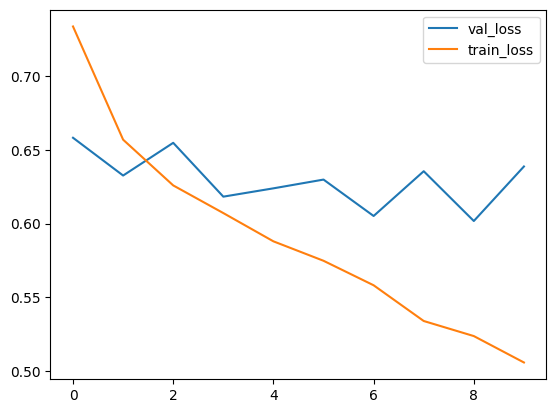

In [ ]:
plt.plot(all_val_loss, label='val_loss')
plt.plot(all_train_loss, label='train_loss')
plt.legend()

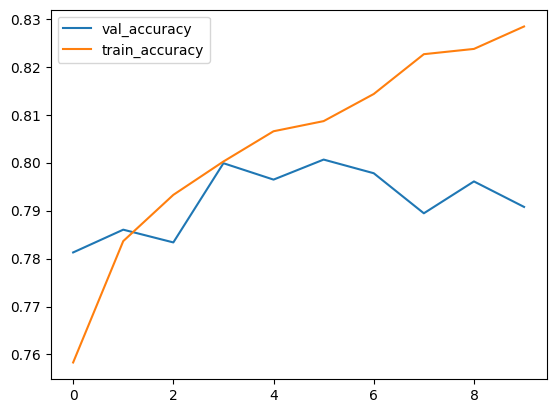

In [ ]:
plt.plot(all_val_accuracy,label='val_accuracy')
plt.plot(all_train_accuracy,label='train_accuracy')
plt.legend()

## Fourth model - ResNet34

In [ ]:
model = models.resnet34(pretrained=True)

# Modify the classifier
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 197MB/s]


In [ ]:
all_train_loss=[]
all_train_accuracy=[]
all_val_loss=[]
all_val_accuracy=[]


In [ ]:
n_epochs = 5
best_accuracy = 0.0

for epoch in range(n_epochs):
    train_loss = 0.0
    train_accuracy = 0.0
    val_loss = 0.0
    val_accuracy = 0.0

    # Train the model
    model.train()
    for images, labels in tqdm(train_loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_accuracy += torch.sum(preds == labels.data)

    train_loss = train_loss / len(train_loader.sampler)
    train_accuracy = train_accuracy.double() / len(train_loader.sampler)

    # Validate the model
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_accuracy += torch.sum(preds == labels.data)

    val_loss = val_loss / len(val_loader.sampler)
    val_accuracy = val_accuracy.double() / len(val_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f}'.format(epoch+1, train_loss, train_accuracy))
    print('\t\tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(val_loss, val_accuracy))

    # Save the model weights if validation accuracy increases
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)
    all_train_accuracy.append(train_accuracy)
    all_val_accuracy.append(val_accuracy)





Validation: 100%|██████████| 165/165 [02:36<00:00,  1.06it/s]


Epoch: 1 	Training Loss: 0.830731 	Training Accuracy: 0.737457
		Validation Loss: 0.896254 	Validation Accuracy: 0.738561


Validation: 100%|██████████| 165/165 [02:40<00:00,  1.03it/s]


Epoch: 2 	Training Loss: 0.759184 	Training Accuracy: 0.748484
		Validation Loss: 0.757533 	Validation Accuracy: 0.740839


Validation: 100%|██████████| 165/165 [02:36<00:00,  1.05it/s]


Epoch: 3 	Training Loss: 0.731073 	Training Accuracy: 0.752960
		Validation Loss: 0.781592 	Validation Accuracy: 0.745965


Validation: 100%|██████████| 165/165 [02:38<00:00,  1.04it/s]


Epoch: 4 	Training Loss: 0.714020 	Training Accuracy: 0.759064
		Validation Loss: 0.733152 	Validation Accuracy: 0.755079


Validation: 100%|██████████| 165/165 [02:37<00:00,  1.05it/s]

Epoch: 5 	Training Loss: 0.702972 	Training Accuracy: 0.763866
		Validation Loss: 0.728506 	Validation Accuracy: 0.752800


In [ ]:
with open('best_model.pth', 'rb') as f:
    model.load_state_dict(torch.load(f))


In [ ]:
# initialize some variables to keep track of testing statistics
test_loss = 0.0
test_accuracy = 0.0

# iterate over the test data
for images, labels in tqdm(test_loader, desc='Testing'):
    images, labels = images.to(device), labels.to(device)

    # compute the model output
    outputs = model(images)

    # calculate the loss
    loss = criterion(outputs, labels)
    test_loss += loss.item() * images.size(0)

    # calculate the accuracy
    _, preds = torch.max(outputs, 1)
    test_accuracy += torch.sum(preds == labels.data)

test_loss = test_loss / len(test_loader.sampler)
test_accuracy = test_accuracy.double() / len(test_loader.sampler)
print(' \tTest Loss: {:.6f} \tTest Accuracy: {:.6f}'.format( test_loss,test_accuracy))

Testing: 100%|██████████| 165/165 [02:39<00:00,  1.03it/s]

 	Test Loss: 0.722475 	Test Accuracy: 0.761869


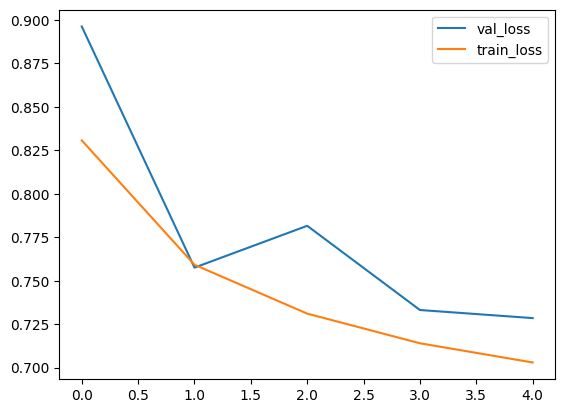

In [ ]:
plt.plot(all_val_loss, label='val_loss')
plt.plot(all_train_loss, label='train_loss')
plt.legend()

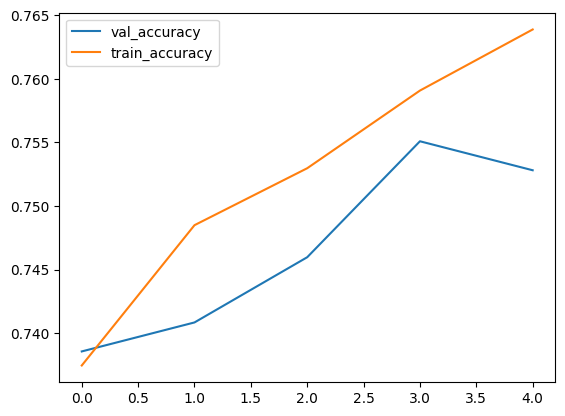

In [ ]:
plt.plot(all_val_accuracy,label='val_accuracy')
plt.plot(all_train_accuracy,label='train_accuracy')
plt.legend()

# Random subset

In [ ]:
!kaggle datasets download -d mariaherrerot/eyepacspreprocess

100% 6.04G/6.04G [03:27<00:00, 23.5MB/s]
100% 6.04G/6.04G [03:27<00:00, 31.3MB/s]


In [ ]:
!unzip eyepacspreprocess.zip

Streaming output truncated to the last 5000 lines.
  inflating: eyepacs_preprocess/eyepacs_preprocess/44260_left.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44260_right.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44261_left.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44261_right.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44262_left.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44262_right.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44263_left.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44263_right.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44264_left.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44264_right.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44265_left.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44265_right.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44267_left.jpeg  
  inflating: eyepacs_preprocess/eyepacs_prepro

Library import

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset, RandomSampler
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler


In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms, models, utils, ops
from skimage import io, transform
from torchsummary import summary
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
import torchvision

In [ ]:
import os
for dirname, _, filenames in os.walk('eyepacs_preprocess'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Streaming output truncated to the last 5000 lines.
eyepacs_preprocess/eyepacs_preprocess/31324_left.jpeg
eyepacs_preprocess/eyepacs_preprocess/13991_left.jpeg
eyepacs_preprocess/eyepacs_preprocess/23575_right.jpeg
eyepacs_preprocess/eyepacs_preprocess/12946_right.jpeg
eyepacs_preprocess/eyepacs_preprocess/30967_right.jpeg
eyepacs_preprocess/eyepacs_preprocess/33529_left.jpeg
eyepacs_preprocess/eyepacs_preprocess/9147_right.jpeg
eyepacs_preprocess/eyepacs_preprocess/30352_right.jpeg
eyepacs_preprocess/eyepacs_preprocess/43863_left.jpeg
eyepacs_preprocess/eyepacs_preprocess/7172_right.jpeg
eyepacs_preprocess/eyepacs_preprocess/26315_right.jpeg
eyepacs_preprocess/eyepacs_preprocess/26234_right.jpeg
eyepacs_preprocess/eyepacs_preprocess/14468_right.jpeg
eyepacs_preprocess/eyepacs_preprocess/10903_right.jpeg
eyepacs_preprocess/eyepacs_preprocess/14008_left.jpeg
eyepacs_preprocess/eyepacs_preprocess/17474_right.jpeg
eyepacs_preprocess/eyepacs_preprocess/2780_right.jpeg
eyepacs_preprocess/eye

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
class EyePACSDataset(Dataset):
    def __init__(self, img_dir, df, transform=None):
        self.img_dir = img_dir
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx, 0] + '.jpeg')
        image = Image.open(img_path)
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
transform = transforms.Compose([transforms.Resize((299, 299)), # 299, 299 for inception, 224, 224 for other
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

In [ ]:
df = pd.read_csv('trainLabels.csv')

In [ ]:
dataset = EyePACSDataset('eyepacs_preprocess/eyepacs_preprocess', df, transform=transform)

In [ ]:
# Divide the dataset into train, test, and validation sets,
num_train = int(len(dataset) * 0.08)
num_test = int(len(dataset) * 0.02)
num_val = int(len(dataset)* .02)

train_indices = np.random.choice(len(dataset), num_train, replace=False)
test_val_indices = list(set(range(len(dataset))) - set(train_indices))
test_indices = np.random.choice(test_val_indices, num_test, replace=False)
val_indices = np.random.choice(len(dataset), num_val, replace = False)
#val_indices = list(set(test_val_indices) - set(test_indices))

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)
val_dataset = Subset(dataset, val_indices)

# Create data loaders for each set
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)


## First model - VGG-16

In [ ]:
model1 = models.vgg16(pretrained=True)
for param in model1.parameters():
    param.requires_grad = False

num_features = model1.classifier[6].in_features
features = list(model1.classifier.children())[:-1]
features.extend([nn.Linear(num_features, 5)])
model1.classifier = nn.Sequential(*features)
model1.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 285MB/s]


In [ ]:
from tqdm import tqdm

n_epochs = 30
best_accuracy = 0.0
cumlosses = []

for epoch in range(n_epochs):
    train_loss = 0.0
    train_accuracy = 0.0
    val_loss = 0.0
    val_accuracy = 0.0

    # Train the model
    model1.train()
    for images, labels in tqdm(train_loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model1(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_accuracy += torch.sum(preds == labels.data)

    train_loss = train_loss / len(train_loader.sampler)
    train_accuracy = train_accuracy.double() / len(train_loader.sampler)

    cumlosses.append(train_loss)

    # Validate the model
    valacc = []
    model1.eval()
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)

            outputs = model1(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_accuracy += torch.sum(preds == labels.data)

    val_loss = val_loss / len(val_loader.sampler)
    val_accuracy = val_accuracy.double() / len(val_loader.sampler)
    valacc.append(val_accuracy)

    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f}'.format(epoch+1, train_loss, train_accuracy))
    print('\t\tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(val_loss, val_accuracy))

    # Save the model weights if validation accuracy increases
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model1.state_dict(), 'best_model1.pth')


Validation: 100%|██████████| 11/11 [00:20<00:00,  1.90s/it]


Epoch: 1 	Training Loss: 0.908258 	Training Accuracy: 0.733618
		Validation Loss: 0.843514 	Validation Accuracy: 0.725071


Validation: 100%|██████████| 11/11 [00:21<00:00,  1.93s/it]


Epoch: 2 	Training Loss: 0.821205 	Training Accuracy: 0.740028
		Validation Loss: 0.840784 	Validation Accuracy: 0.725071


Validation: 100%|██████████| 11/11 [00:21<00:00,  1.94s/it]


Epoch: 3 	Training Loss: 0.802662 	Training Accuracy: 0.746795
		Validation Loss: 0.810595 	Validation Accuracy: 0.725071


Validation: 100%|██████████| 11/11 [00:21<00:00,  1.92s/it]


Epoch: 4 	Training Loss: 0.792324 	Training Accuracy: 0.746083
		Validation Loss: 0.835221 	Validation Accuracy: 0.722222


Validation: 100%|██████████| 11/11 [00:21<00:00,  1.95s/it]


Epoch: 5 	Training Loss: 0.781158 	Training Accuracy: 0.743590
		Validation Loss: 0.803829 	Validation Accuracy: 0.723647


Validation: 100%|██████████| 11/11 [00:21<00:00,  1.98s/it]


Epoch: 6 	Training Loss: 0.772921 	Training Accuracy: 0.745370
		Validation Loss: 0.806549 	Validation Accuracy: 0.719373


Validation: 100%|██████████| 11/11 [00:21<00:00,  1.96s/it]


Epoch: 7 	Training Loss: 0.763852 	Training Accuracy: 0.749644
		Validation Loss: 0.807883 	Validation Accuracy: 0.720798


Validation: 100%|██████████| 11/11 [00:21<00:00,  1.96s/it]


Epoch: 8 	Training Loss: 0.791697 	Training Accuracy: 0.740385
		Validation Loss: 0.904001 	Validation Accuracy: 0.690883


Validation: 100%|██████████| 11/11 [00:21<00:00,  1.95s/it]


Epoch: 9 	Training Loss: 0.771069 	Training Accuracy: 0.743234
		Validation Loss: 0.834877 	Validation Accuracy: 0.726496


Validation: 100%|██████████| 11/11 [00:21<00:00,  1.95s/it]


Epoch: 10 	Training Loss: 0.760621 	Training Accuracy: 0.746083
		Validation Loss: 0.821672 	Validation Accuracy: 0.719373


Validation: 100%|██████████| 11/11 [00:21<00:00,  1.95s/it]


Epoch: 11 	Training Loss: 0.772185 	Training Accuracy: 0.745370
		Validation Loss: 0.833630 	Validation Accuracy: 0.726496


Validation: 100%|██████████| 11/11 [00:21<00:00,  1.97s/it]


Epoch: 12 	Training Loss: 0.747679 	Training Accuracy: 0.753917
		Validation Loss: 0.824416 	Validation Accuracy: 0.720798


Validation: 100%|██████████| 11/11 [00:21<00:00,  1.98s/it]


Epoch: 13 	Training Loss: 0.768485 	Training Accuracy: 0.743590
		Validation Loss: 0.822356 	Validation Accuracy: 0.725071


Validation: 100%|██████████| 11/11 [00:21<00:00,  1.95s/it]


Epoch: 14 	Training Loss: 0.764694 	Training Accuracy: 0.753917
		Validation Loss: 0.840469 	Validation Accuracy: 0.725071


Validation: 100%|██████████| 11/11 [00:21<00:00,  1.96s/it]


Epoch: 15 	Training Loss: 0.759195 	Training Accuracy: 0.751781
		Validation Loss: 0.813048 	Validation Accuracy: 0.725071


Validation: 100%|██████████| 11/11 [00:21<00:00,  1.95s/it]


Epoch: 16 	Training Loss: 0.736024 	Training Accuracy: 0.748575
		Validation Loss: 0.816113 	Validation Accuracy: 0.719373


Validation: 100%|██████████| 11/11 [00:21<00:00,  1.95s/it]


Epoch: 17 	Training Loss: 0.747927 	Training Accuracy: 0.756054
		Validation Loss: 0.867734 	Validation Accuracy: 0.725071


Validation: 100%|██████████| 11/11 [00:21<00:00,  1.97s/it]


Epoch: 18 	Training Loss: 0.741261 	Training Accuracy: 0.748575
		Validation Loss: 0.806303 	Validation Accuracy: 0.722222


Validation: 100%|██████████| 11/11 [00:21<00:00,  1.97s/it]


Epoch: 19 	Training Loss: 0.739251 	Training Accuracy: 0.751781
		Validation Loss: 0.862908 	Validation Accuracy: 0.710826


Validation: 100%|██████████| 11/11 [00:21<00:00,  1.96s/it]


Epoch: 20 	Training Loss: 0.767725 	Training Accuracy: 0.744658
		Validation Loss: 0.810647 	Validation Accuracy: 0.720798


Validation: 100%|██████████| 11/11 [00:21<00:00,  1.95s/it]


Epoch: 21 	Training Loss: 0.727835 	Training Accuracy: 0.761040
		Validation Loss: 0.827591 	Validation Accuracy: 0.710826


Validation: 100%|██████████| 11/11 [00:21<00:00,  1.99s/it]


Epoch: 22 	Training Loss: 0.728400 	Training Accuracy: 0.756054
		Validation Loss: 0.828382 	Validation Accuracy: 0.727920


Validation: 100%|██████████| 11/11 [00:21<00:00,  1.95s/it]


Epoch: 23 	Training Loss: 0.745818 	Training Accuracy: 0.749644
		Validation Loss: 0.804027 	Validation Accuracy: 0.726496


Validation: 100%|██████████| 11/11 [00:21<00:00,  1.97s/it]


Epoch: 24 	Training Loss: 0.736171 	Training Accuracy: 0.758903
		Validation Loss: 0.848811 	Validation Accuracy: 0.720798


Validation: 100%|██████████| 11/11 [00:21<00:00,  1.96s/it]


Epoch: 25 	Training Loss: 0.748095 	Training Accuracy: 0.751425
		Validation Loss: 0.824303 	Validation Accuracy: 0.722222


Validation: 100%|██████████| 11/11 [00:21<00:00,  1.96s/it]


Epoch: 26 	Training Loss: 0.739708 	Training Accuracy: 0.753561
		Validation Loss: 0.816787 	Validation Accuracy: 0.720798


Validation: 100%|██████████| 11/11 [00:21<00:00,  1.95s/it]


Epoch: 27 	Training Loss: 0.743980 	Training Accuracy: 0.736467
		Validation Loss: 0.848233 	Validation Accuracy: 0.725071


Validation: 100%|██████████| 11/11 [00:21<00:00,  1.97s/it]


Epoch: 28 	Training Loss: 0.739945 	Training Accuracy: 0.751425
		Validation Loss: 0.819418 	Validation Accuracy: 0.725071


Validation: 100%|██████████| 11/11 [00:21<00:00,  1.98s/it]


Epoch: 29 	Training Loss: 0.729020 	Training Accuracy: 0.753917
		Validation Loss: 0.820625 	Validation Accuracy: 0.725071


Validation: 100%|██████████| 11/11 [00:21<00:00,  1.97s/it]

Epoch: 30 	Training Loss: 0.719268 	Training Accuracy: 0.756054
		Validation Loss: 0.822017 	Validation Accuracy: 0.722222


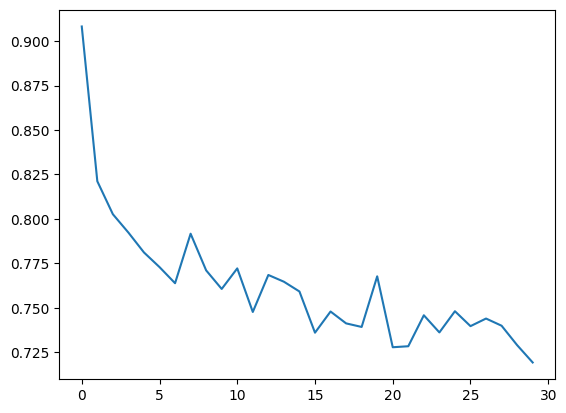

In [ ]:
plt.plot(cumlosses)

In [ ]:
# initialize some variables to keep track of testing statistics
test_loss = 0.0
test_accuracy = 0.0

# iterate over the test data
for images, labels in tqdm(test_loader, desc='Testing'):
    images, labels = images.to(device), labels.to(device)

    # compute the model output
    outputs = model1(images)

    # calculate the loss
    loss = criterion(outputs, labels)
    test_loss += loss.item() * images.size(0)

    # calculate the accuracy
    _, preds = torch.max(outputs, 1)
    test_accuracy += torch.sum(preds == labels.data)

test_loss = test_loss / len(test_loader.sampler)
test_accuracy = test_accuracy.double() / len(test_loader.sampler)
print(' \tTest Loss: {:.6f} \tTest Accuracy: {:.6f}'.format( test_loss,test_accuracy))

Testing: 100%|██████████| 702/702 [00:26<00:00, 26.65it/s]

 	Test Loss: 0.828803 	Test Accuracy: 0.726496


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Second Model

## Second Model - Inception_V3

In [ ]:
model3 = models.inception_v3(pretrained=True)

# Freeze all layers
for param in model3.parameters():
    param.requires_grad = False

# Replace the last fully connected layer
num_features = model3.fc.in_features
model3.fc = nn.Linear(num_features, 6)


model3.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.fc.parameters())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:02<00:00, 40.8MB/s]


In [ ]:
from tqdm import tqdm

n_epochs = 30
best_accuracy = 0.0
cumlosses3 = []

for epoch in range(n_epochs):
    train_loss = 0.0
    train_accuracy = 0.0
    val_loss = 0.0
    val_accuracy = 0.0

    # Train the model
    model3.train()
    for images, labels in tqdm(train_loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model3(images)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs.logits, 1)
        train_accuracy += torch.sum(preds == labels.data)

    train_loss = train_loss / len(train_loader.sampler)
    train_accuracy = train_accuracy.double() / len(train_loader.sampler)

    cumlosses3.append(train_loss)

    # Validate the model
    model3.eval()
    valacc3 =[]
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)

            outputs = model3(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_accuracy += torch.sum(preds == labels.data)

    val_loss = val_loss / len(val_loader.sampler)
    val_accuracy = val_accuracy.double() / len(val_loader.sampler)

    valacc3.append(val_accuracy)

    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f}'.format(epoch+1, train_loss, train_accuracy))
    print('\t\tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(val_loss, val_accuracy))

    # Save the model weights if validation accuracy increases
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model3.state_dict(), 'best_model3.pth')


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


Epoch: 1 	Training Loss: 0.938896 	Training Accuracy: 0.727920
		Validation Loss: 0.847811 	Validation Accuracy: 0.723647


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.59s/it]


Epoch: 2 	Training Loss: 0.822396 	Training Accuracy: 0.741809
		Validation Loss: 0.829135 	Validation Accuracy: 0.727920


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.60s/it]


Epoch: 3 	Training Loss: 0.796793 	Training Accuracy: 0.745370
		Validation Loss: 0.830575 	Validation Accuracy: 0.727920


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.59s/it]


Epoch: 4 	Training Loss: 0.775776 	Training Accuracy: 0.743590
		Validation Loss: 0.836730 	Validation Accuracy: 0.729345


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.59s/it]


Epoch: 5 	Training Loss: 0.761271 	Training Accuracy: 0.746083
		Validation Loss: 0.813000 	Validation Accuracy: 0.732194


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


Epoch: 6 	Training Loss: 0.744222 	Training Accuracy: 0.750000
		Validation Loss: 0.815778 	Validation Accuracy: 0.732194


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


Epoch: 7 	Training Loss: 0.731348 	Training Accuracy: 0.745726
		Validation Loss: 0.841113 	Validation Accuracy: 0.727920


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.58s/it]


Epoch: 8 	Training Loss: 0.732053 	Training Accuracy: 0.748932
		Validation Loss: 0.810747 	Validation Accuracy: 0.732194


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


Epoch: 9 	Training Loss: 0.716955 	Training Accuracy: 0.751068
		Validation Loss: 0.803032 	Validation Accuracy: 0.726496


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.59s/it]


Epoch: 10 	Training Loss: 0.709681 	Training Accuracy: 0.753917
		Validation Loss: 0.824577 	Validation Accuracy: 0.730769


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.58s/it]


Epoch: 11 	Training Loss: 0.698378 	Training Accuracy: 0.755698
		Validation Loss: 0.797016 	Validation Accuracy: 0.735043


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.62s/it]


Epoch: 12 	Training Loss: 0.700022 	Training Accuracy: 0.758547
		Validation Loss: 0.809397 	Validation Accuracy: 0.732194


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.62s/it]


Epoch: 13 	Training Loss: 0.696097 	Training Accuracy: 0.758903
		Validation Loss: 0.795901 	Validation Accuracy: 0.730769


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.62s/it]


Epoch: 14 	Training Loss: 0.674449 	Training Accuracy: 0.762108
		Validation Loss: 0.801678 	Validation Accuracy: 0.733618


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.61s/it]


Epoch: 15 	Training Loss: 0.679539 	Training Accuracy: 0.758903
		Validation Loss: 0.822897 	Validation Accuracy: 0.732194


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.61s/it]


Epoch: 16 	Training Loss: 0.682157 	Training Accuracy: 0.758903
		Validation Loss: 0.804504 	Validation Accuracy: 0.732194


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.61s/it]


Epoch: 17 	Training Loss: 0.684133 	Training Accuracy: 0.761396
		Validation Loss: 0.836071 	Validation Accuracy: 0.732194


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.58s/it]


Epoch: 18 	Training Loss: 0.671393 	Training Accuracy: 0.759259
		Validation Loss: 0.837119 	Validation Accuracy: 0.736467


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.60s/it]


Epoch: 19 	Training Loss: 0.675827 	Training Accuracy: 0.766026
		Validation Loss: 0.812333 	Validation Accuracy: 0.735043


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.62s/it]


Epoch: 20 	Training Loss: 0.675030 	Training Accuracy: 0.762108
		Validation Loss: 0.808437 	Validation Accuracy: 0.730769


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.60s/it]


Epoch: 21 	Training Loss: 0.673324 	Training Accuracy: 0.765313
		Validation Loss: 0.816730 	Validation Accuracy: 0.736467


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


Epoch: 22 	Training Loss: 0.671566 	Training Accuracy: 0.767094
		Validation Loss: 0.824992 	Validation Accuracy: 0.733618


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.60s/it]


Epoch: 23 	Training Loss: 0.671159 	Training Accuracy: 0.757835
		Validation Loss: 0.831981 	Validation Accuracy: 0.732194


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


Epoch: 24 	Training Loss: 0.660883 	Training Accuracy: 0.766382
		Validation Loss: 0.813348 	Validation Accuracy: 0.732194


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.58s/it]


Epoch: 25 	Training Loss: 0.679840 	Training Accuracy: 0.760684
		Validation Loss: 0.811010 	Validation Accuracy: 0.729345


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.60s/it]


Epoch: 26 	Training Loss: 0.641470 	Training Accuracy: 0.767806
		Validation Loss: 0.831838 	Validation Accuracy: 0.730769


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


Epoch: 27 	Training Loss: 0.664355 	Training Accuracy: 0.762108
		Validation Loss: 0.822068 	Validation Accuracy: 0.727920


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


Epoch: 28 	Training Loss: 0.671450 	Training Accuracy: 0.764245
		Validation Loss: 0.827198 	Validation Accuracy: 0.732194


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


Epoch: 29 	Training Loss: 0.663501 	Training Accuracy: 0.767450
		Validation Loss: 0.804946 	Validation Accuracy: 0.735043


Validation: 100%|██████████| 11/11 [00:17<00:00,  1.60s/it]

Epoch: 30 	Training Loss: 0.646881 	Training Accuracy: 0.774929
		Validation Loss: 0.824996 	Validation Accuracy: 0.732194


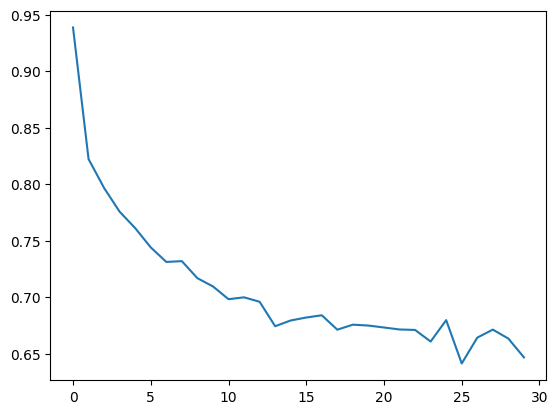

In [ ]:
plt.plot(cumlosses3)

In [ ]:
plt.plot(valacc3)

In [ ]:
# initialize some variables to keep track of testing statistics
test_loss = 0.0
test_accuracy = 0.0

# iterate over the test data
for images, labels in tqdm(test_loader, desc='Testing'):
    images, labels = images.to(device), labels.to(device)

    # compute the model output
    outputs = model3(images)

    # calculate the loss
    loss = criterion(outputs, labels)
    test_loss += loss.item() * images.size(0)

    # calculate the accuracy
    _, preds = torch.max(outputs, 1)
    test_accuracy += torch.sum(preds == labels.data)

test_loss = test_loss / len(test_loader.sampler)
test_accuracy = test_accuracy.double() / len(test_loader.sampler)
print(' \tTest Loss: {:.6f} \tTest Accuracy: {:.6f}'.format( test_loss,test_accuracy))

Testing: 100%|██████████| 702/702 [00:25<00:00, 27.99it/s]

 	Test Loss: 0.844389 	Test Accuracy: 0.735043


## Third Model

In [ ]:
pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.5 MB/s eta 0:00:00


In [ ]:
import timm

In [ ]:
model4 =timm.create_model('efficientnet_b0', pretrained=True)

for param in model4.parameters():
    param.requires_grad = False


num_ftrs = model4.classifier.in_features
model4.classifier = nn.Linear(num_ftrs, 6)

model4.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model4.parameters())

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


In [ ]:
from tqdm import tqdm

n_epochs = 30
best_accuracy = 0.0
cumlosses4 = []

for epoch in range(n_epochs):
    train_loss = 0.0
    train_accuracy = 0.0
    val_loss = 0.0
    val_accuracy = 0.0

    # Train the model
    model4.train()
    for images, labels in tqdm(train_loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model4(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_accuracy += torch.sum(preds == labels.data)

    train_loss = train_loss / len(train_loader.sampler)
    train_accuracy = train_accuracy.double() / len(train_loader.sampler)

    cumlosses4.append(train_loss)

    # Validate the model
    model4.eval()

    valacc4 = []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)

            outputs = model4(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_accuracy += torch.sum(preds == labels.data)

    val_loss = val_loss / len(val_loader.sampler)
    val_accuracy = val_accuracy.double() / len(val_loader.sampler)

    valacc4.append(val_accuracy)

    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f}'.format(epoch+1, train_loss, train_accuracy))
    print('\t\tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(val_loss, val_accuracy))

    # Save the model weights if validation accuracy increases
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model4.state_dict(), 'best_model4.pth')


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


Epoch: 1 	Training Loss: 0.990305 	Training Accuracy: 0.725071
		Validation Loss: 0.878552 	Validation Accuracy: 0.725071


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


Epoch: 2 	Training Loss: 0.820604 	Training Accuracy: 0.743590
		Validation Loss: 0.844699 	Validation Accuracy: 0.725071


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


Epoch: 3 	Training Loss: 0.774325 	Training Accuracy: 0.746083
		Validation Loss: 0.828293 	Validation Accuracy: 0.730769


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


Epoch: 4 	Training Loss: 0.741590 	Training Accuracy: 0.748575
		Validation Loss: 0.822418 	Validation Accuracy: 0.730769


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


Epoch: 5 	Training Loss: 0.717631 	Training Accuracy: 0.754986
		Validation Loss: 0.818406 	Validation Accuracy: 0.732194


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


Epoch: 6 	Training Loss: 0.694707 	Training Accuracy: 0.756766
		Validation Loss: 0.809733 	Validation Accuracy: 0.739316


Validation: 100%|██████████| 11/11 [00:15<00:00,  1.45s/it]


Epoch: 7 	Training Loss: 0.679583 	Training Accuracy: 0.762464
		Validation Loss: 0.820884 	Validation Accuracy: 0.733618


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.47s/it]


Epoch: 8 	Training Loss: 0.658583 	Training Accuracy: 0.768162
		Validation Loss: 0.804947 	Validation Accuracy: 0.735043


Validation: 100%|██████████| 11/11 [00:15<00:00,  1.45s/it]


Epoch: 9 	Training Loss: 0.647511 	Training Accuracy: 0.768519
		Validation Loss: 0.807351 	Validation Accuracy: 0.739316


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.47s/it]


Epoch: 10 	Training Loss: 0.638245 	Training Accuracy: 0.774573
		Validation Loss: 0.798163 	Validation Accuracy: 0.737892


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


Epoch: 11 	Training Loss: 0.622249 	Training Accuracy: 0.777422
		Validation Loss: 0.804604 	Validation Accuracy: 0.739316


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.47s/it]


Epoch: 12 	Training Loss: 0.606365 	Training Accuracy: 0.783476
		Validation Loss: 0.802941 	Validation Accuracy: 0.736467


Validation: 100%|██████████| 11/11 [00:15<00:00,  1.45s/it]


Epoch: 13 	Training Loss: 0.597600 	Training Accuracy: 0.785613
		Validation Loss: 0.802270 	Validation Accuracy: 0.737892


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.47s/it]


Epoch: 14 	Training Loss: 0.599322 	Training Accuracy: 0.786325
		Validation Loss: 0.809788 	Validation Accuracy: 0.732194


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


Epoch: 15 	Training Loss: 0.581840 	Training Accuracy: 0.785613
		Validation Loss: 0.805472 	Validation Accuracy: 0.737892


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


Epoch: 16 	Training Loss: 0.570359 	Training Accuracy: 0.792379
		Validation Loss: 0.807558 	Validation Accuracy: 0.733618


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


Epoch: 17 	Training Loss: 0.563307 	Training Accuracy: 0.789886
		Validation Loss: 0.808452 	Validation Accuracy: 0.737892


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


Epoch: 18 	Training Loss: 0.556230 	Training Accuracy: 0.802350
		Validation Loss: 0.809114 	Validation Accuracy: 0.735043


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


Epoch: 19 	Training Loss: 0.544081 	Training Accuracy: 0.799858
		Validation Loss: 0.805975 	Validation Accuracy: 0.737892


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


Epoch: 20 	Training Loss: 0.538440 	Training Accuracy: 0.805912
		Validation Loss: 0.807846 	Validation Accuracy: 0.730769


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.47s/it]


Epoch: 21 	Training Loss: 0.533570 	Training Accuracy: 0.809117
		Validation Loss: 0.810424 	Validation Accuracy: 0.730769


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


Epoch: 22 	Training Loss: 0.532851 	Training Accuracy: 0.808405
		Validation Loss: 0.814260 	Validation Accuracy: 0.735043


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


Epoch: 23 	Training Loss: 0.526100 	Training Accuracy: 0.810897
		Validation Loss: 0.806309 	Validation Accuracy: 0.733618


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


Epoch: 24 	Training Loss: 0.517024 	Training Accuracy: 0.810541
		Validation Loss: 0.811877 	Validation Accuracy: 0.729345


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


Epoch: 25 	Training Loss: 0.508056 	Training Accuracy: 0.810897
		Validation Loss: 0.812170 	Validation Accuracy: 0.733618


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


Epoch: 26 	Training Loss: 0.496545 	Training Accuracy: 0.821937
		Validation Loss: 0.808538 	Validation Accuracy: 0.736467


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.47s/it]


Epoch: 27 	Training Loss: 0.496670 	Training Accuracy: 0.817664
		Validation Loss: 0.817999 	Validation Accuracy: 0.736467


Validation: 100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


Epoch: 28 	Training Loss: 0.498626 	Training Accuracy: 0.818376
		Validation Loss: 0.808789 	Validation Accuracy: 0.735043


Validation: 100%|██████████| 11/11 [00:15<00:00,  1.44s/it]


Epoch: 29 	Training Loss: 0.488671 	Training Accuracy: 0.826567
		Validation Loss: 0.814654 	Validation Accuracy: 0.733618


Validation: 100%|██████████| 11/11 [00:15<00:00,  1.45s/it]

Epoch: 30 	Training Loss: 0.483534 	Training Accuracy: 0.831197
		Validation Loss: 0.818978 	Validation Accuracy: 0.733618


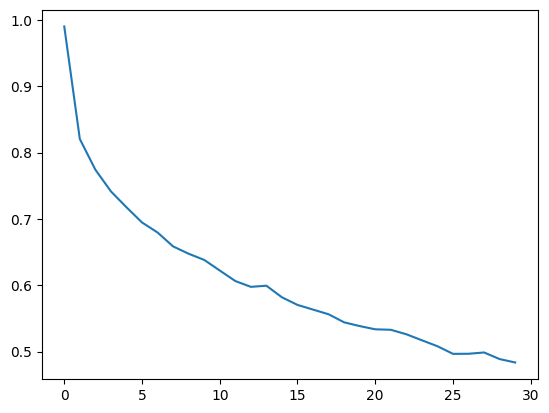

In [ ]:
plt.plot(cumlosses4)

In [ ]:
plt.plot(valacc4)

In [ ]:
# initialize some variables to keep track of testing statistics
test_loss = 0.0
test_accuracy = 0.0

# iterate over the test data
for images, labels in tqdm(test_loader, desc='Testing'):
    images, labels = images.to(device), labels.to(device)

    # compute the model output
    outputs = model4(images)

    # calculate the loss
    loss = criterion(outputs, labels)
    test_loss += loss.item() * images.size(0)

    # calculate the accuracy
    _, preds = torch.max(outputs, 1)
    test_accuracy += torch.sum(preds == labels.data)

test_loss = test_loss / len(test_loader.sampler)
test_accuracy = test_accuracy.double() / len(test_loader.sampler)
print(' \tTest Loss: {:.6f} \tTest Accuracy: {:.6f}'.format( test_loss,test_accuracy))

Testing: 100%|██████████| 702/702 [00:21<00:00, 32.69it/s]

 	Test Loss: 0.873393 	Test Accuracy: 0.726496


# Even subset

In [ ]:
!unzip eyepacspreprocess.zip

Streaming output truncated to the last 5000 lines.
  inflating: eyepacs_preprocess/eyepacs_preprocess/44260_left.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44260_right.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44261_left.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44261_right.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44262_left.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44262_right.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44263_left.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44263_right.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44264_left.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44264_right.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44265_left.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44265_right.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44267_left.jpeg  
  inflating: eyepacs_preprocess/eyepacs_prepro

Library import

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset, RandomSampler
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler


In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms, models, utils, ops
from skimage import io, transform
from torchsummary import summary
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
import torchvision

In [ ]:
import os
for dirname, _, filenames in os.walk('eyepacs_preprocess'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Streaming output truncated to the last 5000 lines.
eyepacs_preprocess/eyepacs_preprocess/2199_left.jpeg
eyepacs_preprocess/eyepacs_preprocess/11962_right.jpeg
eyepacs_preprocess/eyepacs_preprocess/36396_right.jpeg
eyepacs_preprocess/eyepacs_preprocess/3727_left.jpeg
eyepacs_preprocess/eyepacs_preprocess/6560_right.jpeg
eyepacs_preprocess/eyepacs_preprocess/12933_right.jpeg
eyepacs_preprocess/eyepacs_preprocess/41214_left.jpeg
eyepacs_preprocess/eyepacs_preprocess/19073_right.jpeg
eyepacs_preprocess/eyepacs_preprocess/40131_right.jpeg
eyepacs_preprocess/eyepacs_preprocess/37771_left.jpeg
eyepacs_preprocess/eyepacs_preprocess/26721_left.jpeg
eyepacs_preprocess/eyepacs_preprocess/41213_left.jpeg
eyepacs_preprocess/eyepacs_preprocess/2297_left.jpeg
eyepacs_preprocess/eyepacs_preprocess/25413_left.jpeg
eyepacs_preprocess/eyepacs_preprocess/33252_left.jpeg
eyepacs_preprocess/eyepacs_preprocess/33354_right.jpeg
eyepacs_preprocess/eyepacs_preprocess/37583_right.jpeg
eyepacs_preprocess/eyepacs_

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
class EyePACSDataset(Dataset):
    def __init__(self, img_dir, df, transform=None, samples_per_class=None):
        self.img_dir = img_dir
        self.df = df
        self.transform = transform
        self.samples_per_class = samples_per_class

        # find the indices for each class
        self.class_indices = {}
        for i in range(len(self.df)):
            label = self.df.iloc[i, 1]
            if label not in self.class_indices:
                self.class_indices[label] = []
            self.class_indices[label].append(i)

        # find the size of the smallest class
        if self.samples_per_class is None:
            self.samples_per_class = min([len(indices) for indices in self.class_indices.values()])

    def __len__(self):
        return len(self.class_indices) * self.samples_per_class

    def __getitem__(self, idx):
        # find the index and label for the current example
        label_idx = idx % len(self.class_indices)
        label = list(self.class_indices.keys())[label_idx]
        examples = self.class_indices[label]
        example_idx = np.random.choice(examples, size=self.samples_per_class, replace=False)[idx // len(self.class_indices)]

        # load the image and apply the transform
        img_path = os.path.join(self.img_dir, self.df.iloc[example_idx, 0] + '.jpeg')
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
transform = transforms.Compose([transforms.Resize((299, 299)), # 299, 299 for inception, 224, 224 for other
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

In [ ]:
df = pd.read_csv('trainLabels.csv')

In [ ]:
dataset = EyePACSDataset('eyepacs_preprocess/eyepacs_preprocess', df, transform=transform)

In [ ]:
# Divide the dataset into train, test, and validation sets
num_train = int(len(dataset) * 0.7)
num_test = int(len(dataset) * 0.15)
num_val = len(dataset) - num_train - num_test

train_indices = np.random.choice(len(dataset), num_train, replace=False)
test_val_indices = list(set(range(len(dataset))) - set(train_indices))
test_indices = np.random.choice(test_val_indices, num_test, replace=False)
val_indices = list(set(test_val_indices) - set(test_indices))

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)
val_dataset = Subset(dataset, val_indices)

# Create data loaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)



## Fisrt Model: VGG-16

In [ ]:
model1 = models.vgg16(pretrained=True)
for param in model1.parameters():
    param.requires_grad = False

num_features = model1.classifier[6].in_features
features = list(model1.classifier.children())[:-1]
features.extend([nn.Linear(num_features, 5)])
model1.classifier = nn.Sequential(*features)
model1.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 154MB/s]


In [ ]:
from tqdm import tqdm

n_epochs = 20
best_accuracy = 0.0
cumlosses = []

for epoch in range(n_epochs):
    train_loss = 0.0
    train_accuracy = 0.0
    val_loss = 0.0
    val_accuracy = 0.0

    # Train the model
    model1.train()
    for images, labels in tqdm(train_loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model1(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_accuracy += torch.sum(preds == labels.data)

    train_loss = train_loss / len(train_loader.sampler)
    train_accuracy = train_accuracy.double() / len(train_loader.sampler)

    cumlosses.append(train_loss)

    # Validate the model
    valacc = []
    model1.eval()
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)

            outputs = model1(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_accuracy += torch.sum(preds == labels.data)

    val_loss = val_loss / len(val_loader.sampler)
    val_accuracy = val_accuracy.double() / len(val_loader.sampler)
    valacc.append(val_accuracy)

    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f}'.format(epoch+1, train_loss, train_accuracy))
    print('\t\tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(val_loss, val_accuracy))

    # Save the model weights if validation accuracy increases
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model1.state_dict(), 'best_model1.pth')


Validation: 100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Epoch: 1 	Training Loss: 1.484187 	Training Accuracy: 0.333737
		Validation Loss: 1.344738 	Validation Accuracy: 0.431262


Validation: 100%|██████████| 17/17 [00:16<00:00,  1.01it/s]


Epoch: 2 	Training Loss: 1.421803 	Training Accuracy: 0.374899
		Validation Loss: 1.371024 	Validation Accuracy: 0.416196


Validation: 100%|██████████| 17/17 [00:17<00:00,  1.00s/it]


Epoch: 3 	Training Loss: 1.400646 	Training Accuracy: 0.390234
		Validation Loss: 1.312022 	Validation Accuracy: 0.416196


Validation: 100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Epoch: 4 	Training Loss: 1.379044 	Training Accuracy: 0.406376
		Validation Loss: 1.322995 	Validation Accuracy: 0.427495


Validation: 100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Epoch: 5 	Training Loss: 1.393735 	Training Accuracy: 0.400323
		Validation Loss: 1.274489 	Validation Accuracy: 0.482109


Validation: 100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Epoch: 6 	Training Loss: 1.388808 	Training Accuracy: 0.393462
		Validation Loss: 1.238633 	Validation Accuracy: 0.474576


Validation: 100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Epoch: 7 	Training Loss: 1.378916 	Training Accuracy: 0.399919
		Validation Loss: 1.280855 	Validation Accuracy: 0.419962


Validation: 100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Epoch: 8 	Training Loss: 1.398678 	Training Accuracy: 0.402341
		Validation Loss: 1.297343 	Validation Accuracy: 0.391714


Validation: 100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Epoch: 9 	Training Loss: 1.366755 	Training Accuracy: 0.397902
		Validation Loss: 1.229304 	Validation Accuracy: 0.451977


Validation: 100%|██████████| 17/17 [00:16<00:00,  1.00it/s]


Epoch: 10 	Training Loss: 1.366572 	Training Accuracy: 0.411622
		Validation Loss: 1.264946 	Validation Accuracy: 0.455744


Validation: 100%|██████████| 17/17 [00:16<00:00,  1.00it/s]


Epoch: 11 	Training Loss: 1.371460 	Training Accuracy: 0.403551
		Validation Loss: 1.227138 	Validation Accuracy: 0.478343


Validation: 100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Epoch: 12 	Training Loss: 1.378252 	Training Accuracy: 0.413236
		Validation Loss: 1.277894 	Validation Accuracy: 0.421846


Validation: 100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Epoch: 13 	Training Loss: 1.368076 	Training Accuracy: 0.416465
		Validation Loss: 1.243365 	Validation Accuracy: 0.459510


Validation: 100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Epoch: 14 	Training Loss: 1.388464 	Training Accuracy: 0.400726
		Validation Loss: 1.229992 	Validation Accuracy: 0.448211


Validation: 100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Epoch: 15 	Training Loss: 1.409876 	Training Accuracy: 0.399516
		Validation Loss: 1.240488 	Validation Accuracy: 0.470810


Validation: 100%|██████████| 17/17 [00:17<00:00,  1.00s/it]


Epoch: 16 	Training Loss: 1.385975 	Training Accuracy: 0.414447
		Validation Loss: 1.282735 	Validation Accuracy: 0.427495


Validation: 100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Epoch: 17 	Training Loss: 1.380145 	Training Accuracy: 0.410412
		Validation Loss: 1.321347 	Validation Accuracy: 0.393597


Validation: 100%|██████████| 17/17 [00:17<00:00,  1.00s/it]


Epoch: 18 	Training Loss: 1.362300 	Training Accuracy: 0.424132
		Validation Loss: 1.260519 	Validation Accuracy: 0.435028


Validation: 100%|██████████| 17/17 [00:17<00:00,  1.00s/it]


Epoch: 19 	Training Loss: 1.393963 	Training Accuracy: 0.407990
		Validation Loss: 1.226152 	Validation Accuracy: 0.444444


Validation: 100%|██████████| 17/17 [00:16<00:00,  1.01it/s]


Epoch: 20 	Training Loss: 1.387508 	Training Accuracy: 0.410815
		Validation Loss: 1.252477 	Validation Accuracy: 0.433145


Validation: 100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Epoch: 21 	Training Loss: 1.409122 	Training Accuracy: 0.397094
		Validation Loss: 1.210042 	Validation Accuracy: 0.499058


Validation: 100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Epoch: 22 	Training Loss: 1.394576 	Training Accuracy: 0.405569
		Validation Loss: 1.234653 	Validation Accuracy: 0.467043


Validation: 100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Epoch: 23 	Training Loss: 1.373069 	Training Accuracy: 0.406780
		Validation Loss: 1.205153 	Validation Accuracy: 0.482109


Validation: 100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Epoch: 24 	Training Loss: 1.359369 	Training Accuracy: 0.414447
		Validation Loss: 1.215190 	Validation Accuracy: 0.453861


Validation: 100%|██████████| 17/17 [00:17<00:00,  1.00s/it]


Epoch: 25 	Training Loss: 1.378770 	Training Accuracy: 0.420097
		Validation Loss: 1.264117 	Validation Accuracy: 0.451977


Validation: 100%|██████████| 17/17 [00:16<00:00,  1.00it/s]


Epoch: 26 	Training Loss: 1.421405 	Training Accuracy: 0.411622
		Validation Loss: 1.218853 	Validation Accuracy: 0.478343


Validation: 100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Epoch: 27 	Training Loss: 1.424573 	Training Accuracy: 0.397498
		Validation Loss: 1.194362 	Validation Accuracy: 0.502825


Validation: 100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Epoch: 28 	Training Loss: 1.357725 	Training Accuracy: 0.412026
		Validation Loss: 1.224554 	Validation Accuracy: 0.476460


Validation: 100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Epoch: 29 	Training Loss: 1.383427 	Training Accuracy: 0.397094
		Validation Loss: 1.185994 	Validation Accuracy: 0.482109


Validation: 100%|██████████| 17/17 [00:17<00:00,  1.03s/it]

Epoch: 30 	Training Loss: 1.367665 	Training Accuracy: 0.412429
		Validation Loss: 1.226878 	Validation Accuracy: 0.459510


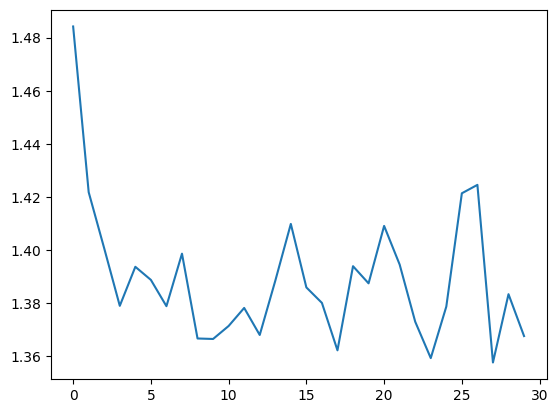

In [ ]:
plt.plot(cumlosses)

In [ ]:
# initialize some variables to keep track of testing statistics
test_loss = 0.0
test_accuracy = 0.0

# iterate over the test data
for images, labels in tqdm(test_loader, desc='Testing'):
    images, labels = images.to(device), labels.to(device)

    # compute the model output
    outputs = model1(images)

    # calculate the loss
    loss = criterion(outputs, labels)
    test_loss += loss.item() * images.size(0)

    # calculate the accuracy
    _, preds = torch.max(outputs, 1)
    test_accuracy += torch.sum(preds == labels.data)

test_loss = test_loss / len(test_loader.sampler)
test_accuracy = test_accuracy.double() / len(test_loader.sampler)
print(' \tTest Loss: {:.6f} \tTest Accuracy: {:.6f}'.format( test_loss,test_accuracy))

Testing: 100%|██████████| 17/17 [00:17<00:00,  1.03s/it]

 	Test Loss: 1.240301 	Test Accuracy: 0.433145


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Second Model: Inception_v3

In [ ]:
model3 = models.inception_v3(pretrained=True)

# Freeze all layers
for param in model3.parameters():
    param.requires_grad = False

# Replace the last fully connected layer
num_features = model3.fc.in_features
model3.fc = nn.Linear(num_features, 6)


model3.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.fc.parameters())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 76.6MB/s] 


In [ ]:
from tqdm import tqdm

n_epochs = 20
best_accuracy = 0.0
cumlosses3 = []

for epoch in range(n_epochs):
    train_loss = 0.0
    train_accuracy = 0.0
    val_loss = 0.0
    val_accuracy = 0.0

    # Train the model
    model3.train()
    for images, labels in tqdm(train_loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model3(images)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs.logits, 1)
        train_accuracy += torch.sum(preds == labels.data)

    train_loss = train_loss / len(train_loader.sampler)
    train_accuracy = train_accuracy.double() / len(train_loader.sampler)

    cumlosses3.append(train_loss)

    # Validate the model
    model3.eval()
    valacc3 =[]
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)

            outputs = model3(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_accuracy += torch.sum(preds == labels.data)

    val_loss = val_loss / len(val_loader.sampler)
    val_accuracy = val_accuracy.double() / len(val_loader.sampler)

    valacc3.append(val_accuracy)

    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f}'.format(epoch+1, train_loss, train_accuracy))
    print('\t\tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(val_loss, val_accuracy))

    # Save the model weights if validation accuracy increases
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model3.state_dict(), 'best_model3.pth')


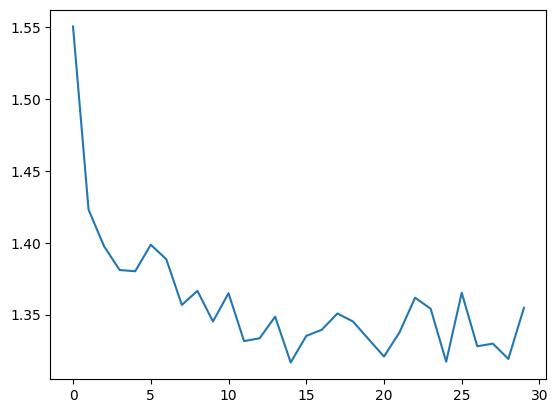

In [ ]:
plt.plot(cumlosses3)

In [ ]:
# initialize some variables to keep track of testing statistics
test_loss = 0.0
test_accuracy = 0.0

# iterate over the test data
for images, labels in tqdm(test_loader, desc='Testing'):
    images, labels = images.to(device), labels.to(device)

    # compute the model output
    outputs = model3(images)

    # calculate the loss
    loss = criterion(outputs, labels)
    test_loss += loss.item() * images.size(0)

    # calculate the accuracy
    _, preds = torch.max(outputs, 1)
    test_accuracy += torch.sum(preds == labels.data)

test_loss = test_loss / len(test_loader.sampler)
test_accuracy = test_accuracy.double() / len(test_loader.sampler)
print(' \tTest Loss: {:.6f} \tTest Accuracy: {:.6f}'.format( test_loss,test_accuracy))

Testing: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]

 	Test Loss: 1.173070 	Test Accuracy: 0.510358


## Third Model: Efficient Net

In [ ]:
pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.9 MB/s eta 0:00:00


In [ ]:
import timm

In [ ]:
model4 =timm.create_model('efficientnet_b0', pretrained=True)

for param in model4.parameters():
    param.requires_grad = False


num_ftrs = model4.classifier.in_features
model4.classifier = nn.Linear(num_ftrs, 6)

model4.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model4.parameters())

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


In [ ]:
from tqdm import tqdm

n_epochs = 50
best_accuracy = 0.0
cumlosses4 = []

model4.train()

for epoch in range(n_epochs):
    train_loss = 0.0
    train_accuracy = 0.0
    val_loss = 0.0
    val_accuracy = 0.0

    # Train the model
    model4.train()
    for images, labels in tqdm(train_loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model4(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_accuracy += torch.sum(preds == labels.data)

    train_loss = train_loss / len(train_loader.sampler)
    train_accuracy = train_accuracy.double() / len(train_loader.sampler)

    cumlosses4.append(train_loss)

    # Validate the model
    model4.eval()

    valacc4 = []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)

            outputs = model4(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_accuracy += torch.sum(preds == labels.data)

    val_loss = val_loss / len(val_loader.sampler)
    val_accuracy = val_accuracy.double() / len(val_loader.sampler)

    valacc4.append(val_accuracy)

    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f}'.format(epoch+1, train_loss, train_accuracy))
    print('\t\tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(val_loss, val_accuracy))

    # Save the model weights if validation accuracy increases
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model4.state_dict(), 'best_model4.pth')


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.28it/s]


Epoch: 1 	Training Loss: 1.051155 	Training Accuracy: 0.560129
		Validation Loss: 0.992604 	Validation Accuracy: 0.570621


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.27it/s]


Epoch: 2 	Training Loss: 1.066954 	Training Accuracy: 0.549637
		Validation Loss: 1.006791 	Validation Accuracy: 0.576271


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.28it/s]


Epoch: 3 	Training Loss: 1.034207 	Training Accuracy: 0.563358
		Validation Loss: 0.975102 	Validation Accuracy: 0.587571


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.29it/s]


Epoch: 4 	Training Loss: 1.043856 	Training Accuracy: 0.571025
		Validation Loss: 0.983554 	Validation Accuracy: 0.612053


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.29it/s]


Epoch: 5 	Training Loss: 1.007259 	Training Accuracy: 0.582728
		Validation Loss: 0.976439 	Validation Accuracy: 0.598870


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


Epoch: 6 	Training Loss: 1.040494 	Training Accuracy: 0.567393
		Validation Loss: 0.971867 	Validation Accuracy: 0.649718


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.29it/s]


Epoch: 7 	Training Loss: 1.039167 	Training Accuracy: 0.562954
		Validation Loss: 0.957562 	Validation Accuracy: 0.608286


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.27it/s]


Epoch: 8 	Training Loss: 1.035597 	Training Accuracy: 0.560936
		Validation Loss: 1.009574 	Validation Accuracy: 0.578154


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


Epoch: 9 	Training Loss: 1.012443 	Training Accuracy: 0.568200
		Validation Loss: 0.967403 	Validation Accuracy: 0.602637


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


Epoch: 10 	Training Loss: 1.008132 	Training Accuracy: 0.582728
		Validation Loss: 1.014857 	Validation Accuracy: 0.581921


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.28it/s]


Epoch: 11 	Training Loss: 1.034430 	Training Accuracy: 0.567797
		Validation Loss: 0.969696 	Validation Accuracy: 0.596987


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.28it/s]


Epoch: 12 	Training Loss: 1.045845 	Training Accuracy: 0.566990
		Validation Loss: 0.965176 	Validation Accuracy: 0.623352


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.27it/s]


Epoch: 13 	Training Loss: 1.043542 	Training Accuracy: 0.556497
		Validation Loss: 0.962898 	Validation Accuracy: 0.596987


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.29it/s]


Epoch: 14 	Training Loss: 1.029171 	Training Accuracy: 0.566182
		Validation Loss: 0.981993 	Validation Accuracy: 0.596987


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


Epoch: 15 	Training Loss: 1.020999 	Training Accuracy: 0.570621
		Validation Loss: 0.917329 	Validation Accuracy: 0.634652


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.29it/s]


Epoch: 16 	Training Loss: 1.031480 	Training Accuracy: 0.574657
		Validation Loss: 0.954564 	Validation Accuracy: 0.625235


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.27it/s]


Epoch: 17 	Training Loss: 1.027559 	Training Accuracy: 0.574253
		Validation Loss: 0.986654 	Validation Accuracy: 0.623352


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch: 18 	Training Loss: 1.028922 	Training Accuracy: 0.572236
		Validation Loss: 0.971447 	Validation Accuracy: 0.596987


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.27it/s]


Epoch: 19 	Training Loss: 1.037713 	Training Accuracy: 0.567797
		Validation Loss: 0.945115 	Validation Accuracy: 0.617702


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch: 20 	Training Loss: 1.022458 	Training Accuracy: 0.581114
		Validation Loss: 0.953606 	Validation Accuracy: 0.615819


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.27it/s]


Epoch: 21 	Training Loss: 1.013286 	Training Accuracy: 0.573043
		Validation Loss: 0.938935 	Validation Accuracy: 0.619586


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


Epoch: 22 	Training Loss: 0.979627 	Training Accuracy: 0.581114
		Validation Loss: 0.983907 	Validation Accuracy: 0.576271


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch: 23 	Training Loss: 1.009848 	Training Accuracy: 0.574657
		Validation Loss: 0.943155 	Validation Accuracy: 0.623352


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch: 24 	Training Loss: 0.991462 	Training Accuracy: 0.583132
		Validation Loss: 0.916343 	Validation Accuracy: 0.662900


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch: 25 	Training Loss: 1.003258 	Training Accuracy: 0.584746
		Validation Loss: 0.990191 	Validation Accuracy: 0.574388


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch: 26 	Training Loss: 1.014833 	Training Accuracy: 0.573043
		Validation Loss: 0.964785 	Validation Accuracy: 0.595104


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch: 27 	Training Loss: 1.041353 	Training Accuracy: 0.562954
		Validation Loss: 0.950837 	Validation Accuracy: 0.621469


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch: 28 	Training Loss: 1.019349 	Training Accuracy: 0.573446
		Validation Loss: 0.988012 	Validation Accuracy: 0.613936


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.22it/s]


Epoch: 29 	Training Loss: 1.008956 	Training Accuracy: 0.572639
		Validation Loss: 0.945830 	Validation Accuracy: 0.617702


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


Epoch: 30 	Training Loss: 0.998041 	Training Accuracy: 0.581517
		Validation Loss: 0.938718 	Validation Accuracy: 0.612053


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch: 31 	Training Loss: 1.009158 	Training Accuracy: 0.575868
		Validation Loss: 0.936145 	Validation Accuracy: 0.621469


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.28it/s]


Epoch: 32 	Training Loss: 1.023443 	Training Accuracy: 0.573043
		Validation Loss: 0.965201 	Validation Accuracy: 0.604520


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.28it/s]


Epoch: 33 	Training Loss: 1.002600 	Training Accuracy: 0.592413
		Validation Loss: 0.918268 	Validation Accuracy: 0.617702


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch: 34 	Training Loss: 0.980529 	Training Accuracy: 0.597256
		Validation Loss: 0.923353 	Validation Accuracy: 0.606403


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch: 35 	Training Loss: 1.004699 	Training Accuracy: 0.588378
		Validation Loss: 0.874286 	Validation Accuracy: 0.629002


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch: 36 	Training Loss: 1.026097 	Training Accuracy: 0.572639
		Validation Loss: 0.960050 	Validation Accuracy: 0.612053


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch: 37 	Training Loss: 0.991343 	Training Accuracy: 0.589588
		Validation Loss: 0.963970 	Validation Accuracy: 0.600753


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch: 38 	Training Loss: 0.979244 	Training Accuracy: 0.597256
		Validation Loss: 0.908144 	Validation Accuracy: 0.634652


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.21it/s]


Epoch: 39 	Training Loss: 0.994509 	Training Accuracy: 0.593624
		Validation Loss: 0.895910 	Validation Accuracy: 0.634652


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch: 40 	Training Loss: 0.983968 	Training Accuracy: 0.571832
		Validation Loss: 0.892190 	Validation Accuracy: 0.640301


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.22it/s]


Epoch: 41 	Training Loss: 1.010193 	Training Accuracy: 0.573850
		Validation Loss: 0.935402 	Validation Accuracy: 0.600753


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch: 42 	Training Loss: 0.988848 	Training Accuracy: 0.587571
		Validation Loss: 0.972571 	Validation Accuracy: 0.604520


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch: 43 	Training Loss: 0.998422 	Training Accuracy: 0.563761
		Validation Loss: 0.921185 	Validation Accuracy: 0.630885


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.22it/s]


Epoch: 44 	Training Loss: 1.000528 	Training Accuracy: 0.587974
		Validation Loss: 0.888005 	Validation Accuracy: 0.661017


Validation: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]


Epoch: 45 	Training Loss: 1.007152 	Training Accuracy: 0.574657
		Validation Loss: 0.916193 	Validation Accuracy: 0.621469


Validation: 100%|██████████| 17/17 [00:14<00:00,  1.20it/s]


Epoch: 46 	Training Loss: 1.005416 	Training Accuracy: 0.572639
		Validation Loss: 0.961180 	Validation Accuracy: 0.613936


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch: 47 	Training Loss: 1.012042 	Training Accuracy: 0.567393
		Validation Loss: 0.939891 	Validation Accuracy: 0.621469


Validation: 100%|██████████| 17/17 [00:14<00:00,  1.20it/s]


Epoch: 48 	Training Loss: 0.990073 	Training Accuracy: 0.585956
		Validation Loss: 0.889617 	Validation Accuracy: 0.653484


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.22it/s]


Epoch: 49 	Training Loss: 0.992290 	Training Accuracy: 0.583535
		Validation Loss: 0.928717 	Validation Accuracy: 0.629002


Validation:   0%|          | 0/17 [00:00<?, ?it/s]

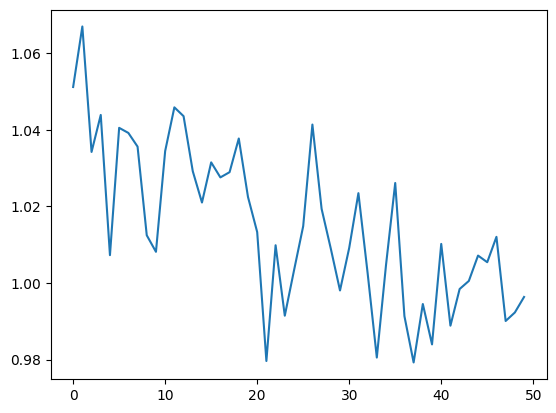

In [ ]:
plt.plot(cumlosses4)

In [ ]:
# initialize some variables to keep track of testing statistics
test_loss = 0.0
test_accuracy = 0.0

model4.eval()

# iterate over the test data
for images, labels in tqdm(test_loader, desc='Testing'):
    images, labels = images.to(device), labels.to(device)

    # compute the model output
    outputs = model4(images)

    # calculate the loss
    loss = criterion(outputs, labels)
    test_loss += loss.item() * images.size(0)

    # calculate the accuracy
    _, preds = torch.max(outputs, 1)
    test_accuracy += torch.sum(preds == labels.data)

test_loss = test_loss / len(test_loader.sampler)
test_accuracy = test_accuracy.double() / len(test_loader.sampler)
print(' \tTest Loss: {:.6f} \tTest Accuracy: {:.6f}'.format( test_loss,test_accuracy))

Testing: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]

 	Test Loss: 0.959435 	Test Accuracy: 0.634652


In [ ]:
import os
from tqdm import tqdm
os.environ['KAGGLE_USERNAME'] = 'ruslangokhmanjh'
os.environ['KAGGLE_KEY'] = '7a976a45a77cad69be7de9827c3ee494'

In [ ]:
!kaggle datasets download -d mariaherrerot/eyepacspreprocess

100% 6.04G/6.04G [00:33<00:00, 216MB/s]
100% 6.04G/6.04G [00:33<00:00, 194MB/s]


In [ ]:
!unzip eyepacspreprocess.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: eyepacs_preprocess/eyepacs_preprocess/44260_left.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44260_right.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44261_left.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44261_right.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44262_left.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44262_right.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44263_left.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44263_right.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44264_left.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44264_right.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44265_left.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44265_right.jpeg  
  inflating: eyepacs_preprocess/eyepacs_preprocess/44267_left.jpeg  
  inflating: eyepacs_preproce

Library import

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, Subset, RandomSampler
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms, models, utils, ops
from skimage import io, transform
from torchsummary import summary
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
import torchvision
import numpy as np

In [ ]:
import os
for dirname, _, filenames in os.walk('eyepacs_preprocess'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
class EyePACSDataset(Dataset):
    def __init__(self, img_dir, df, transform=None, samples_per_class=None):
        self.img_dir = img_dir
        self.df = df
        self.transform = transform
        self.samples_per_class = samples_per_class

        # find the indices for each class
        self.class_indices = {}
        for i in range(len(self.df)):
            label = self.df.iloc[i, 1]
            if label not in self.class_indices:
                self.class_indices[label] = []
            self.class_indices[label].append(i)

        # find the size of the smallest class
        if self.samples_per_class is None:
            self.samples_per_class = min([len(indices) for indices in self.class_indices.values()])

    def __len__(self):
        return len(self.class_indices) * self.samples_per_class

    def __getitem__(self, idx):
        # find the index and label for the current example
        label_idx = idx % len(self.class_indices)
        label = list(self.class_indices.keys())[label_idx]
        examples = self.class_indices[label]
        example_idx = np.random.choice(examples, size=self.samples_per_class, replace=False)[idx // len(self.class_indices)]

        # load the image and apply the transform
        img_path = os.path.join(self.img_dir, self.df.iloc[example_idx, 0] + '.jpeg')
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

In [ ]:
df = pd.read_csv('trainLabels.csv')

In [ ]:
df.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [ ]:
df.tail()

,image,level
35103,44347_right,0
35104,44348_left,0
35105,44348_right,0
35106,44349_left,0
35107,44349_right,1


In [ ]:
dataset = EyePACSDataset('eyepacs_preprocess/eyepacs_preprocess', df, transform=transform)

In [ ]:
# Divide the dataset into train, test, and validation sets
num_train = int(len(dataset) * 0.7)
num_test = int(len(dataset) * 0.15)
num_val = len(dataset) - num_train - num_test

train_indices = np.random.choice(len(dataset), num_train, replace=False)
test_val_indices = list(set(range(len(dataset))) - set(train_indices))
test_indices = np.random.choice(test_val_indices, num_test, replace=False)
val_indices = list(set(test_val_indices) - set(test_indices))

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)
val_dataset = Subset(dataset, val_indices)

# Create data loaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


## Fourth mode: DenseNet121

In [ ]:
model = models.densenet121(pretrained=True)

# Modify the classifier
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 5)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
all_train_loss=[]
all_train_accuracy=[]
all_val_loss=[]
all_val_accuracy=[]


In [ ]:
n_epochs = 5
best_accuracy = 0.0

for epoch in range(n_epochs):
    train_loss = 0.0
    train_accuracy = 0.0
    val_loss = 0.0
    val_accuracy = 0.0

    # Train the model
    model.train()
    for images, labels in tqdm(train_loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_accuracy += torch.sum(preds == labels.data)

    train_loss = train_loss / len(train_loader.sampler)
    train_accuracy = train_accuracy.double() / len(train_loader.sampler)

    # Validate the model
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_accuracy += torch.sum(preds == labels.data)

    val_loss = val_loss / len(val_loader.sampler)
    val_accuracy = val_accuracy.double() / len(val_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f}'.format(epoch+1, train_loss, train_accuracy))
    print('\t\tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(val_loss, val_accuracy))

    # Save the model weights if validation accuracy increases
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)
    all_train_accuracy.append(train_accuracy)
    all_val_accuracy.append(val_accuracy)





Validation: 100%|██████████| 165/165 [03:18<00:00,  1.20s/it]


Epoch: 1 	Training Loss: 0.815113 	Training Accuracy: 0.734568
		Validation Loss: 0.761291 	Validation Accuracy: 0.750142


Training:  50%|█████     | 386/768 [16:50<16:30,  2.59s/it]

In [ ]:
with open('best_model.pth', 'rb') as f:
    model.load_state_dict(torch.load(f))


In [ ]:
# initialize some variables to keep track of testing statistics
test_loss = 0.0
test_accuracy = 0.0

# iterate over the test data
for images, labels in tqdm(test_loader, desc='Testing'):
    images, labels = images.to(device), labels.to(device)

    # compute the model output
    outputs = model(images)

    # calculate the loss
    loss = criterion(outputs, labels)
    test_loss += loss.item() * images.size(0)

    # calculate the accuracy
    _, preds = torch.max(outputs, 1)
    test_accuracy += torch.sum(preds == labels.data)

test_loss = test_loss / len(test_loader.sampler)
test_accuracy = test_accuracy.double() / len(test_loader.sampler)
print(' \tTest Loss: {:.6f} \tTest Accuracy: {:.6f}'.format( test_loss,test_accuracy))

Testing: 100%|██████████| 165/165 [02:32<00:00,  1.08it/s]

 	Test Loss: 0.638486 	Test Accuracy: 0.799278


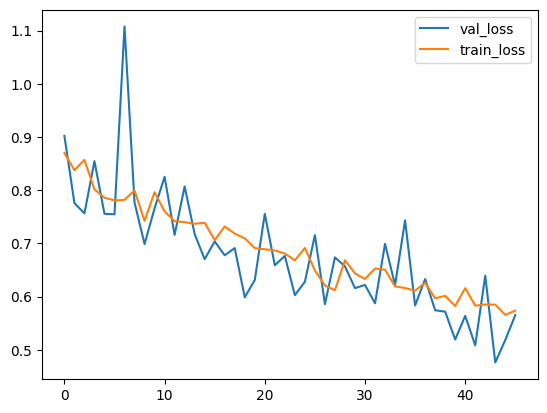

In [ ]:
plt.plot(all_val_loss, label='val_loss')
plt.plot(all_train_loss, label='train_loss')
plt.legend()

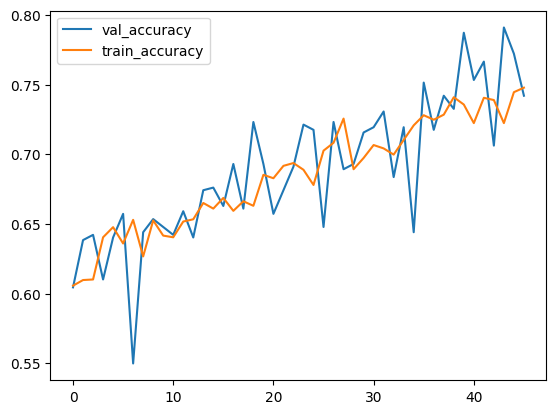

In [ ]:
plt.plot(all_val_accuracy,label='val_accuracy')
plt.plot(all_train_accuracy,label='train_accuracy')
plt.legend()